In [17]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader
import torchvision.transforms as transforms

from PIL import Image
import rasterio

In [3]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Running on device: {device}")

Running on device: cpu


In [4]:
csv_path = "/atlas/u/erikrozi/housing_event_pred/data/train_seasonal_eff.csv"
root_dir = "/atlas/u/pliu1/housing_event_pred/data/houses_new/"

In [7]:
df = pd.read_csv(csv_path).drop(["Unnamed: 0"], axis=1)
df

,year.built,eff.year.built,region,sentinel_2016_1,sentinel_2016_2,sentinel_2016_3,sentinel_2016_4,sentinel_2017_1,sentinel_2017_2,sentinel_2017_3,...,sentinel_2018_3,sentinel_2018_4,sentinel_2019_1,sentinel_2019_2,sentinel_2019_3,sentinel_2019_4,sentinel_2020_1,sentinel_2020_2,sentinel_2020_3,sentinel_2020_4
0,2018,2018,dallas,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...
1,2017,2017,houston,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...
2,2016,2016,houston,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...
3,2017,2017,austin,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...
4,2017,2017,austin,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_event_pred/data/houses_...,/atlas/u/pliu1/housing_even

In [25]:
idx = 1
row = df.iloc[idx]
img_locs = row[df.columns.str.contains("sentinel_")].to_numpy()
images = torch.FloatTensor([rasterio.open(name).read() for name in img_locs])
images.shape

In [27]:
def show_series(images):
    max_clamp = 3000
    gamma = 1
    fig, axs = plt.subplots(5,4, figsize=(12, 15))

    for i in range(images.shape[0]):
        image = images[i]
        image = torch.Tensor(image[0:3]).permute(1, 2, 0).numpy()
        image = np.clip(image, 0, max_clamp) 
        image = (255 * (image / max_clamp)**(1/gamma)).astype(np.uint8)
        axs[i // 4, i%4].imshow(image)
        axs[i // 4, i%4].axis('off')
        axs[i // 4, i%4].set_title(f"Year {i // 4 + 2016}, Month: {(i % 4) * 3 + 1}")
    plt.show()
#show_series(img_loc[0])

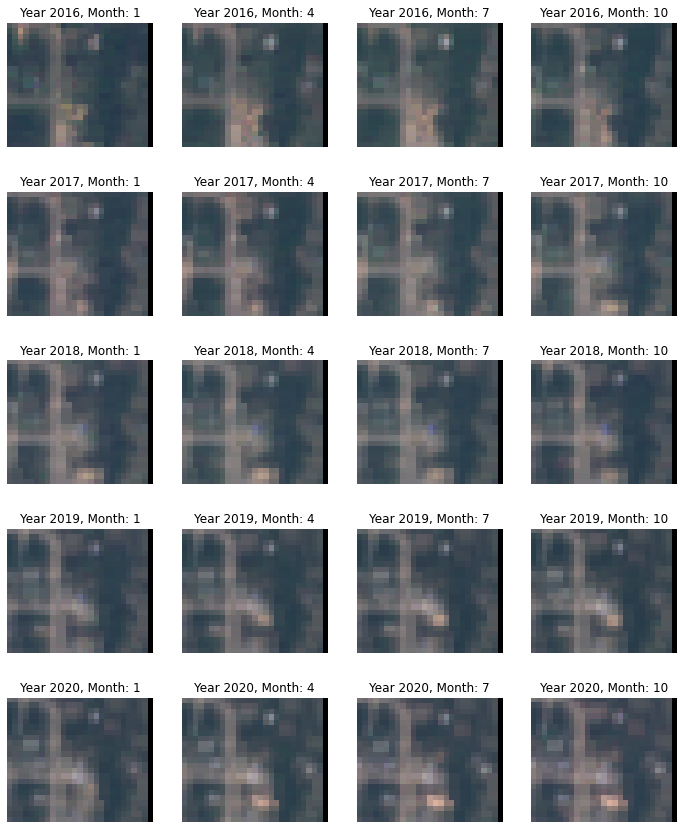

In [29]:
show_series(images)

In [30]:
class Select(torch.nn.Module):
    """
    Selects channels by index along given dimension.
    
    Args:
        dim (int) - Dimension to select along
        indices (list of int) - Indices to keep
    """
    def __init__(self,
                 dim=-3,
                 indices=[0,1,2]):
        super(Select, self).__init__()
        self.dim = dim
        self.indices = indices
    
    def forward(self, x):
        x = x.transpose(0, self.dim)
        x = x[self.indices]
        x = x.transpose(0, self.dim)
        return x
   
class CustomScale(torch.nn.Module):
    """
    Applies affine transformation each value in a tensor, and applies a clamp.
    
    Args:
        scale (float): Value to multiply each tensor value by
        shift (float): Constant to add to scaled values
        clamp (2-tuple of float or None): Lower and upper bounds to clamp to,
            None for no clamping
    """
    def __init__(self,
                 scale=1/6400,
                 shift=0,
                 clamp=(0.0, 1.0)
                ):
        super(CustomScale, self).__init__()
        self.scale = scale
        self.shift = shift
        self.clamp = clamp
    
    def forward(self, x):
        return (x * self.scale + self.shift).clamp(self.clamp[0], self.clamp[1])

In [31]:
SCALE = 2**16
norm_mean=np.array([1377, 1354, 1381, 2356]) / SCALE
norm_std=np.array([540, 398, 327, 515]) / SCALE
    
transformations = [
    transforms.CenterCrop(size=(32, 32)), 
    CustomScale(scale=1/SCALE, clamp=(0, 1.0)),
    transforms.Normalize(mean=norm_mean, std=norm_std),
    Select(dim=-3, indices=[0,1,2]),
]

transform = transforms.Compose(transformations)